# Visualizations of Save Our Shores Cleanup Data 2013-2022

The data consisted of 1-2 xslx files per year, with a wide variety of item names, types and site names. Code for data cleanup and plots can be found at https://github.com/jennyfolkesson/cleanupShores

When possible, item categories have a similar stucture to those in the 2023 Monterey Bay National Marine Sanctuary Marine Debris report.

This document will be updated with more graphs as data is further explored.

In [1]:
import circlify
import glob
import numpy as np
import os
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
from pprint import pprint
import tabulate

import cleanup as cleanup 
import plots as plots

import plotly.io as pio
from plotly.offline import init_notebook_mode

pio.renderers.default = "notebook_connected"
init_notebook_mode(connected=True)

Read all file and combines them into one if file isn't already saved

In [2]:
data_dir = '/Users/jenny.folkesson/Data/SOS Cleanup Data 2013-2022'
existing_file = glob.glob(os.path.join(data_dir, 'merged_sos_data.csv'))
if len(existing_file) == 1:
    sos_data = pd.read_csv(existing_file[0])
else:
    sos_data = cleanup.merge_data(data_dir)
    sos_data.to_csv(os.path.join(data_dir, "merged_sos_data.csv"), index=False)

# The 'Other categories are strings and not useful in this analysis
sos_data.drop(['Other.1', 'Other.2', 'Other.3'], axis=1, inplace=True)

Below you can see the structure of the combined 2013-2022 data set. All the columns and the first five rows are on display.

In [3]:
sos_data.head()

,Date,Data Collection,Duration (Hrs),County/City,Cleanup Site,Cleaned Size (Sq Miles),Adult Volunteers,Youth Volunteers,Trash (lbs),Recycling (lbs),...,Food Wrappers,Tobacco,Straws/Stirrers,Syringes/Needles,Aluminum Foil,Footwear,Shopping Carts,Car Parts,Bikes,Car Batteries
0,2013-01-12,NaN,2.0,Watsonville/Santa Cruz County,Manresa State Beach,2,24.0,NaN,20,11,...,11.0,1948.0,7.0,7.0,109.0,59.0,5.0,0.0,0.0,2.0
1,2013-01-12,NaN,2.0,Monterey/Monterey,Del Monte Beach,NaN,35.0,NaN,119,28,...,170.0,10.0,90.0,0.0,16.0,1.0,0.0,0.0,2.0,0.0
2,2013-01-18,NaN,2.0,Santa Cruz/Santa Cruz,New Brighton State Beach,1,32.0,NaN,5,0,...,1.0,0.0,1.0,0.0,6.0,0.0,0.0,2.0,0.0,0.0
3,2013-01-18,NaN,2.0,Santa Cruz/Santa Cruz,Seabright State Beach,NaN,40.0,NaN,40,20,...,29.0,NaN,5.0,NaN,1.0,3.0,NaN,NaN,3.0,NaN
4,2013-01-19,NaN,3.0,Aptos/Santa Cruz,Seacliff State Beach,2,51.0,NaN,33,5,...,182.0,2.0,52.0,2.0,35.0,4.0,0.0,0.0,0.0,0.0


## Plot circle packing graph for all items collected 2013-2022

This graph shows the total amount of items of the given categories that have been cleaned up by Save Our Shores from 2013 to 2023. The circle sizes correspond to the number of items. When circles are too small to display the text within them, the text has been removed, and you can instead hover over the circle to see the item category and number.

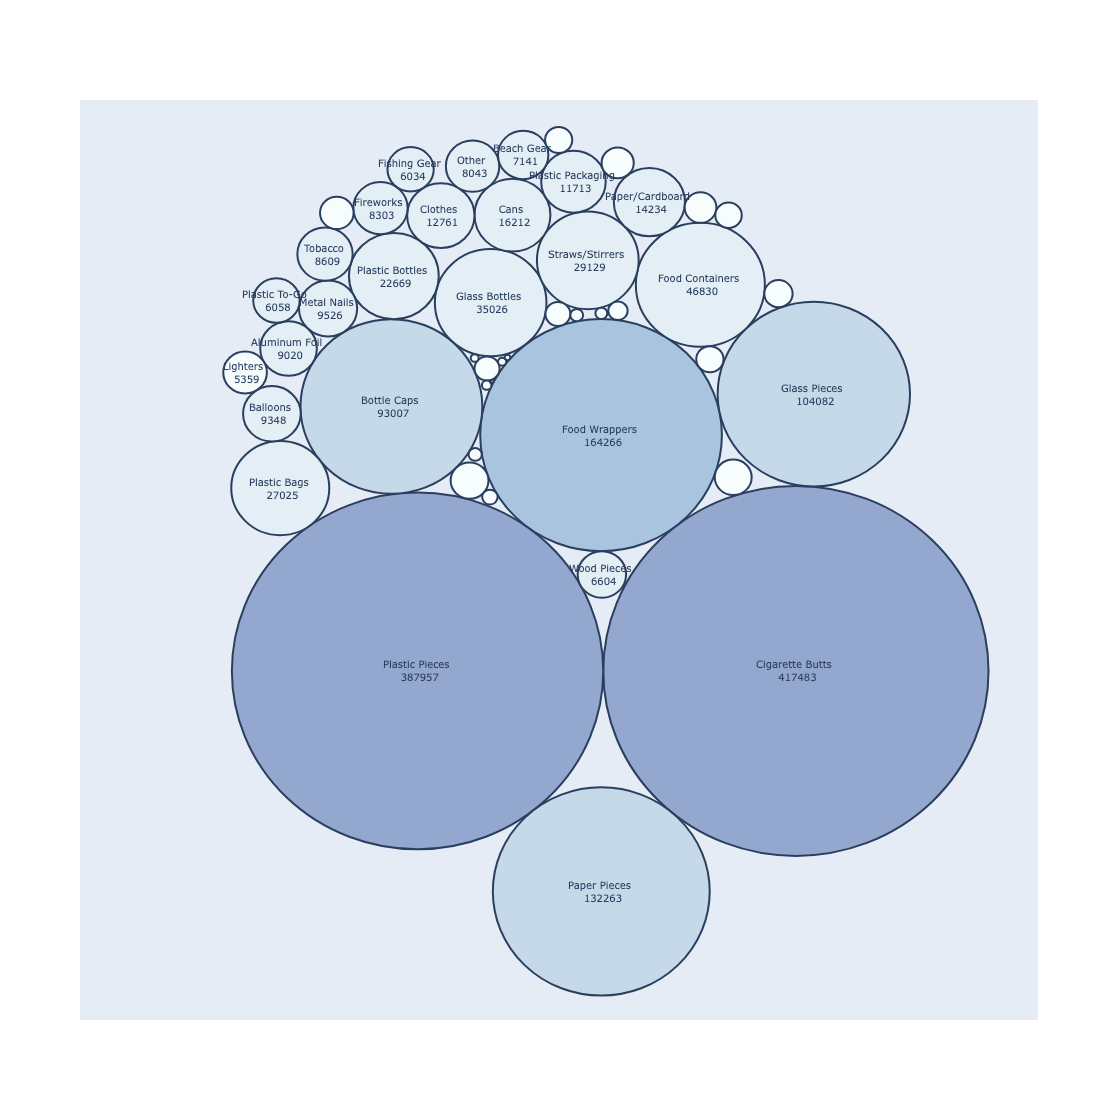

In [4]:
fig = plots.circle_packing_graph(sos_data)
fig.show()

The above graph is a circle packing graph which shows the total number of items cleaned up by Save Our Shores 2013-2022, sorted by the most common categories.

We can show the same information as a treemap, see below.

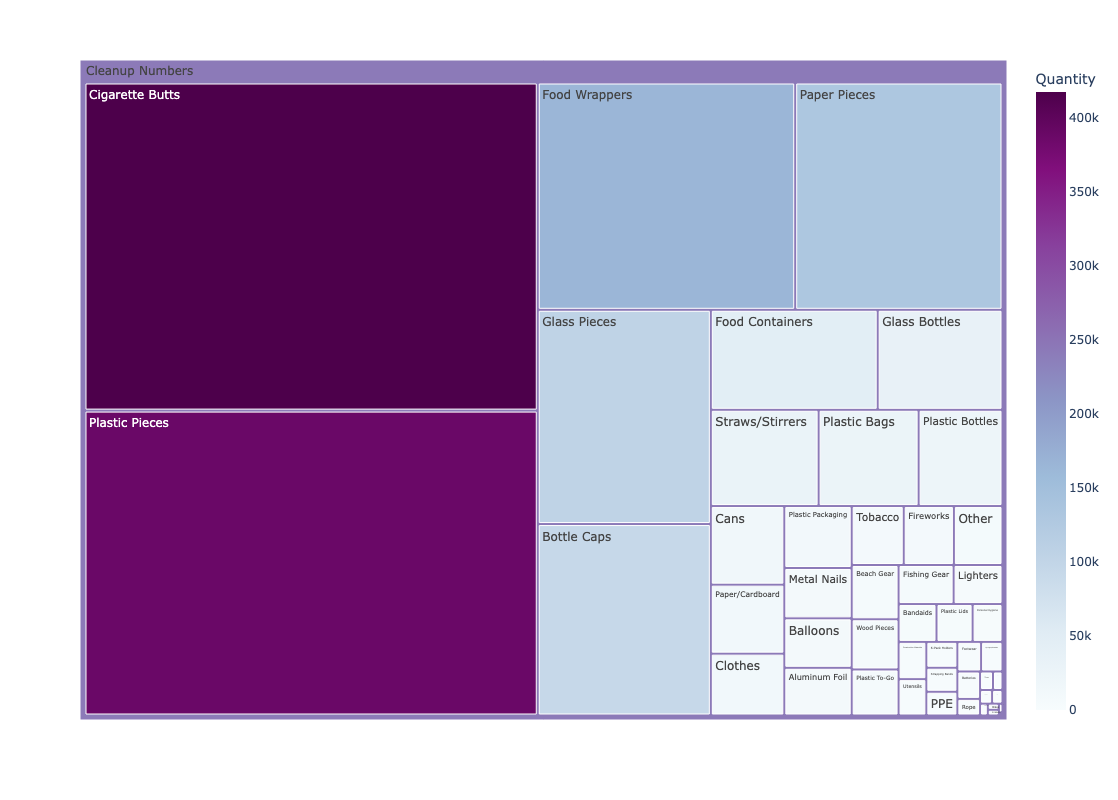

In [5]:
fig = plots.treemap_graph(sos_data)
fig.show()

The treemap graph above shows total number of items cleaned up 2013-2022 by category.

# Explore the Data by Cleanup Site

In the last section we looked at total number of items cleaned up over the years by Save Our Shores. Now we'll look at number of volunteers and number of items cleaned up by site.

There may be some overlap of site names as there were multiple names and spellings for what appeared to be similar sites. Some sites were located by lon, lat coordinates instead of site names, and those are not yet included here.
The code where site names are consolidated is here: https://github.com/jennyfolkesson/cleanupShores/blob/main/cleanup.py#L410

In [6]:
sos_sites = sos_data.copy()
sos_sites = sos_sites.groupby('Cleanup Site').sum()
sos_sites = sos_sites.reset_index()
# NOAA counted youth volunteers as half adult volunteers
sos_sites['Total Volunteers'] = sos_sites['Adult Volunteers'] + 0.5 * sos_sites['Youth Volunteers']
# Drop sites with no stats on volunteer numbers
sos_sites.drop(sos_sites[sos_sites['Total Volunteers'] <= 100].index, inplace=True)

Plot number of volunteers by cleanup site.

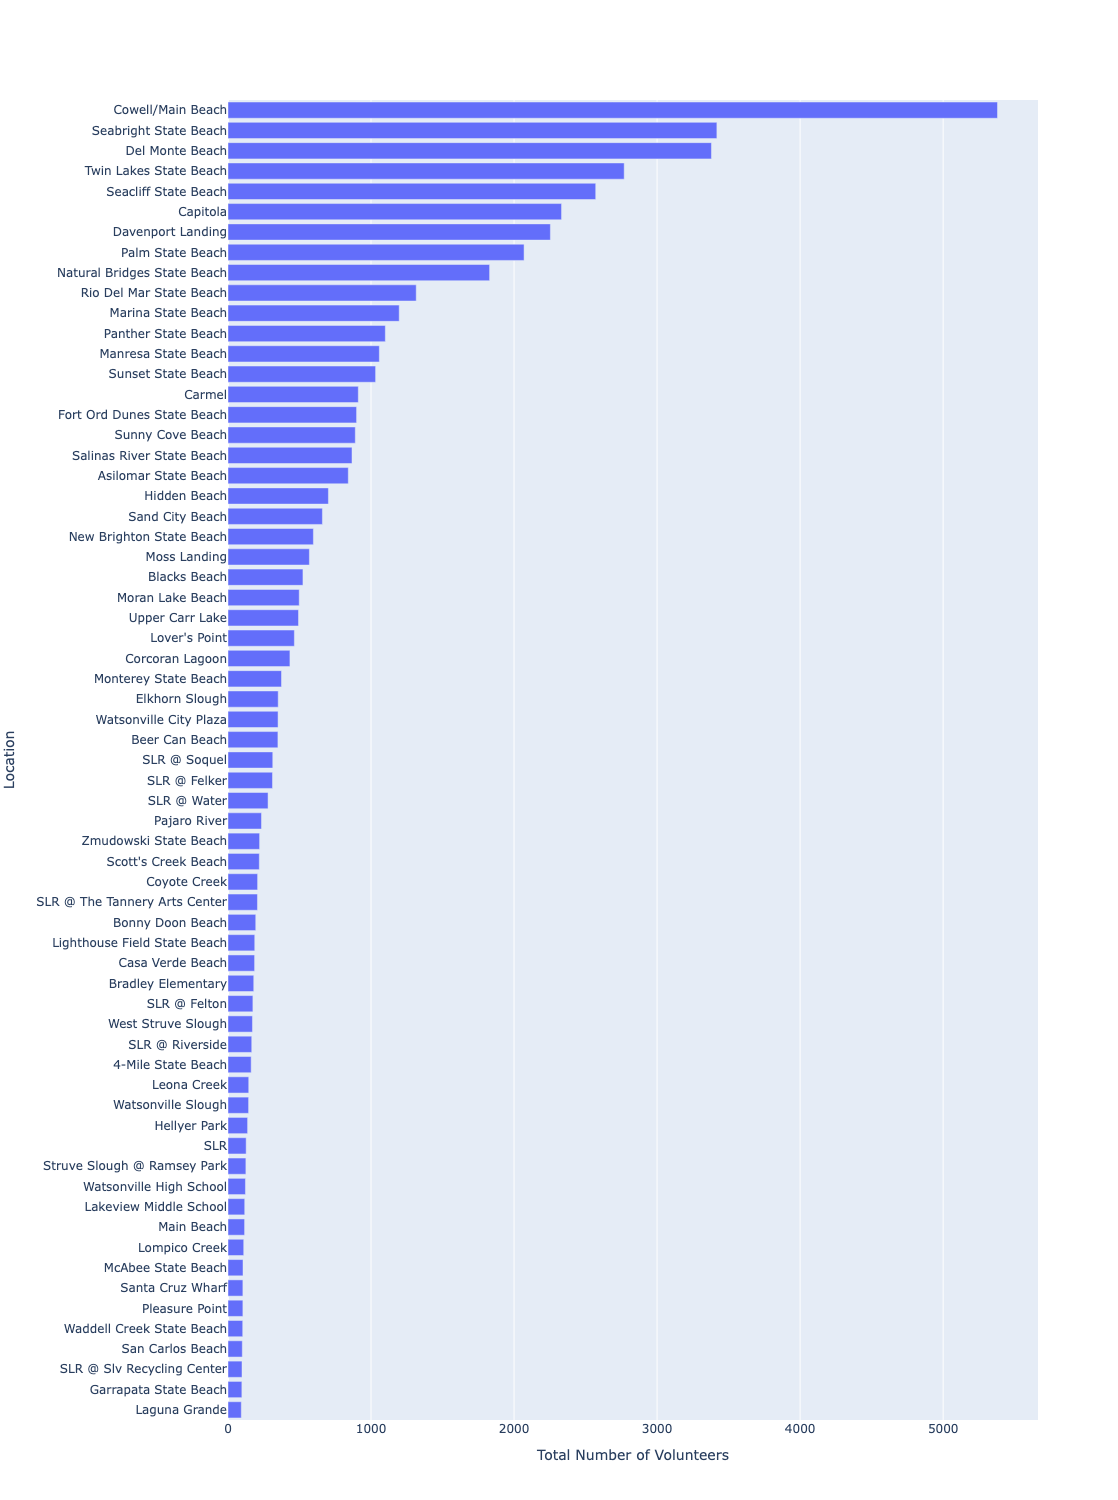

In [7]:
fig = go.Figure()
fig.add_trace(go.Bar(
    y=sos_sites['Cleanup Site'],
    x=sos_sites['Adult Volunteers'],
    orientation='h',
    name='Total Cleanup Volunteers',
))
fig.update_layout(
    autosize=False,
    width=1100,
    height=1500,
    yaxis_title='Location',
    xaxis_title='Total Number of Volunteers',
    yaxis={'categoryorder':'total ascending'}
)
fig.show()

This figure shows the total number of volunteers that have been involved in a cleanup event 2013-2022 per cleanup site. Youth volunteers, when reported, are counted as half an adult volunteer in line with the NOAA Marine Debris Report.
Cleanup sites with less than a total of 100 volunteers are not displayed.

In [8]:
# Add total items as a column
sos_data['Total Items'] = cleanup.sum_items(sos_data, col_sum=False)
sos_sites = sos_data.groupby('Cleanup Site').sum()
sos_sites = sos_sites.reset_index()
# Drop sites with no stats on volunteer numbers
sos_sites.drop(sos_sites[sos_sites['Total Items'] <= 5000].index, inplace=True)

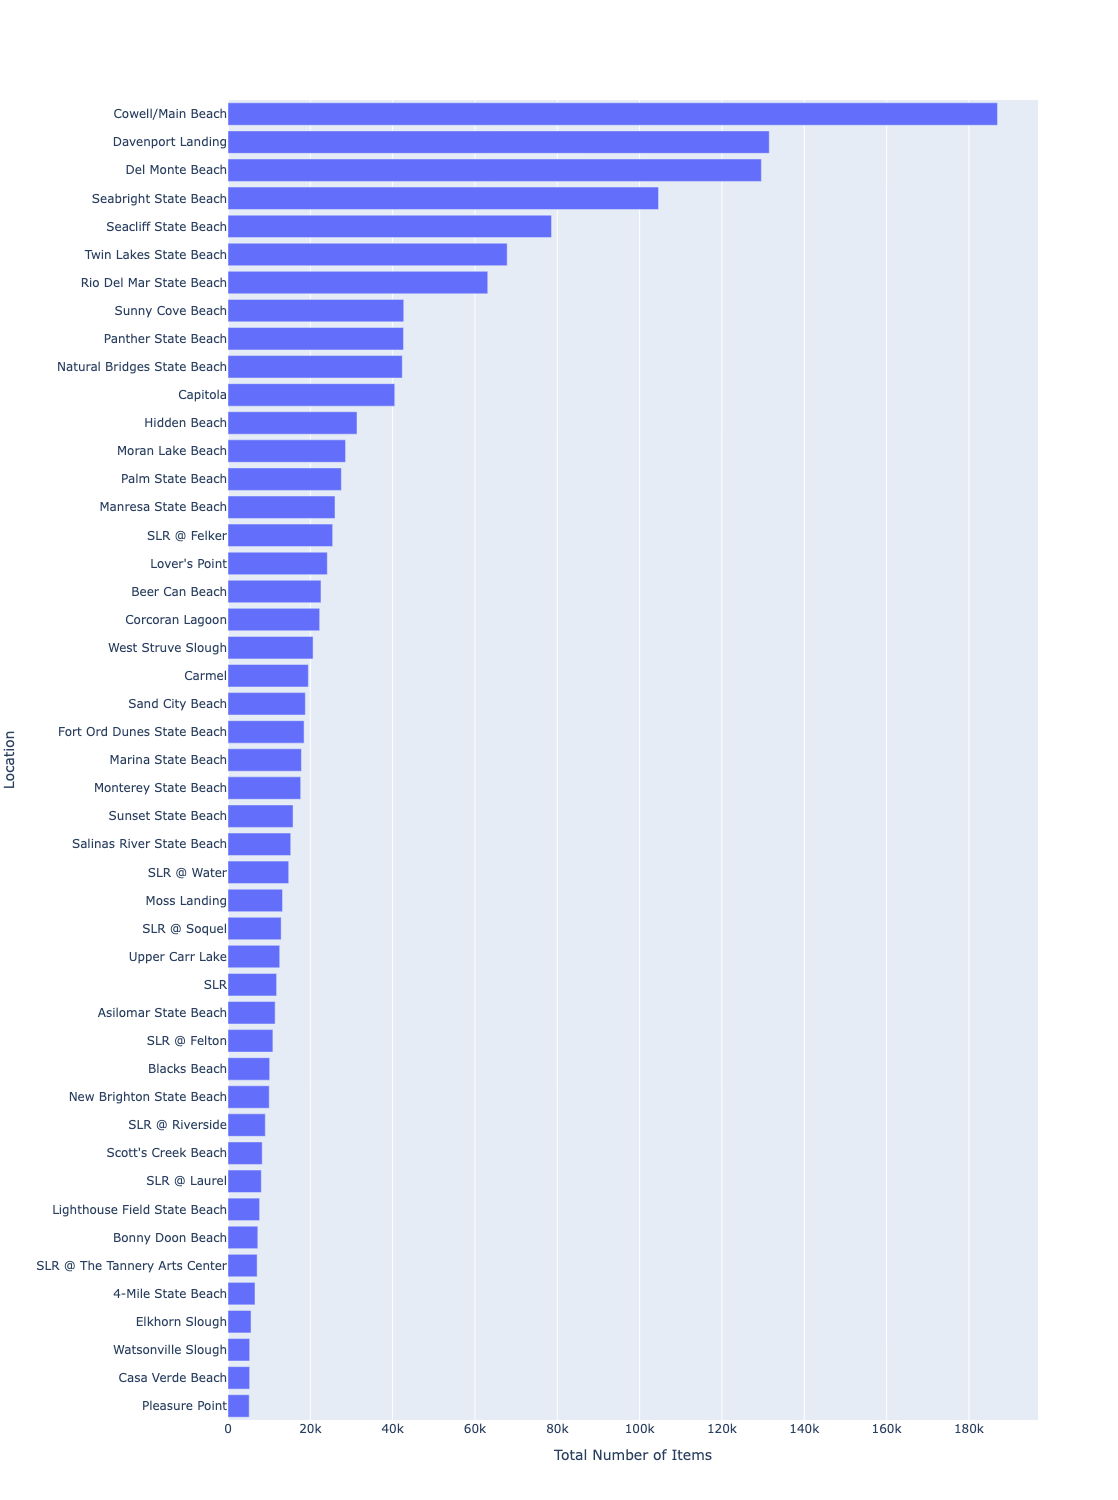

In [9]:
fig = go.Figure()
fig.add_trace(go.Bar(
    y=sos_sites['Cleanup Site'],
    x=sos_sites['Total Items'],
    orientation='h',
    name='Total Number of Items Cleaned Up',
))
fig.update_layout(
    autosize=False,
    width=1100,
    height=1500,
    yaxis_title='Location',
    xaxis_title='Total Number of Items',
    yaxis={'categoryorder':'total ascending'}
)
fig.show()

Total number of items cleaned up from 2013-2022 by cleanup site. Sites with less than 5000 items are not displayed.

# Longitudinal Evaluation of Cleanup Items

Here we'll look at the number of items cleaned up every year from 2013-2022. In order to evaluate if the number of items cleaned up are influenced by the number of volunteers and the number of hours they worked we would also need these numbers for each year, but it appears that these numbers are missing for the years 2013-2016 and 2020-2021, at least in the data I've been working with.

In [10]:
sos_data['Date'] = pd.to_datetime(sos_data['Date'], errors='coerce')
sos_data.dropna(subset=['Date'], inplace=True)

sos_data['Total Volunteers'] = sos_data['Adult Volunteers'].fillna(0) + 0.5 * sos_data['Youth Volunteers'].fillna(0)
nonnumeric_cols = cleanup.NONNUMERIC_COLS
nonnumeric_cols.append('Total Volunteers')
nonnumeric_cols.append('Total Items')

volunteers = sos_data.groupby(sos_data.Date.dt.year)['Total Volunteers'].sum()
annual_data = pd.DataFrame({'Year':volunteers.index, 'Total Volunteers':volunteers.values})
annual_data = annual_data.reset_index(drop=True)
item_cols = []
for col in sos_data.columns:
    if col not in cleanup.NONNUMERIC_COLS:
        item_cols.append(col)
        col_sum = sos_data.groupby(sos_data.Date.dt.year)[col].sum()
        col_sum = col_sum.reset_index(drop=True)
        annual_data = pd.concat([annual_data, col_sum], axis=1)

Create bar plots where each bar represents a year, and different colored parts of the bar are different items.

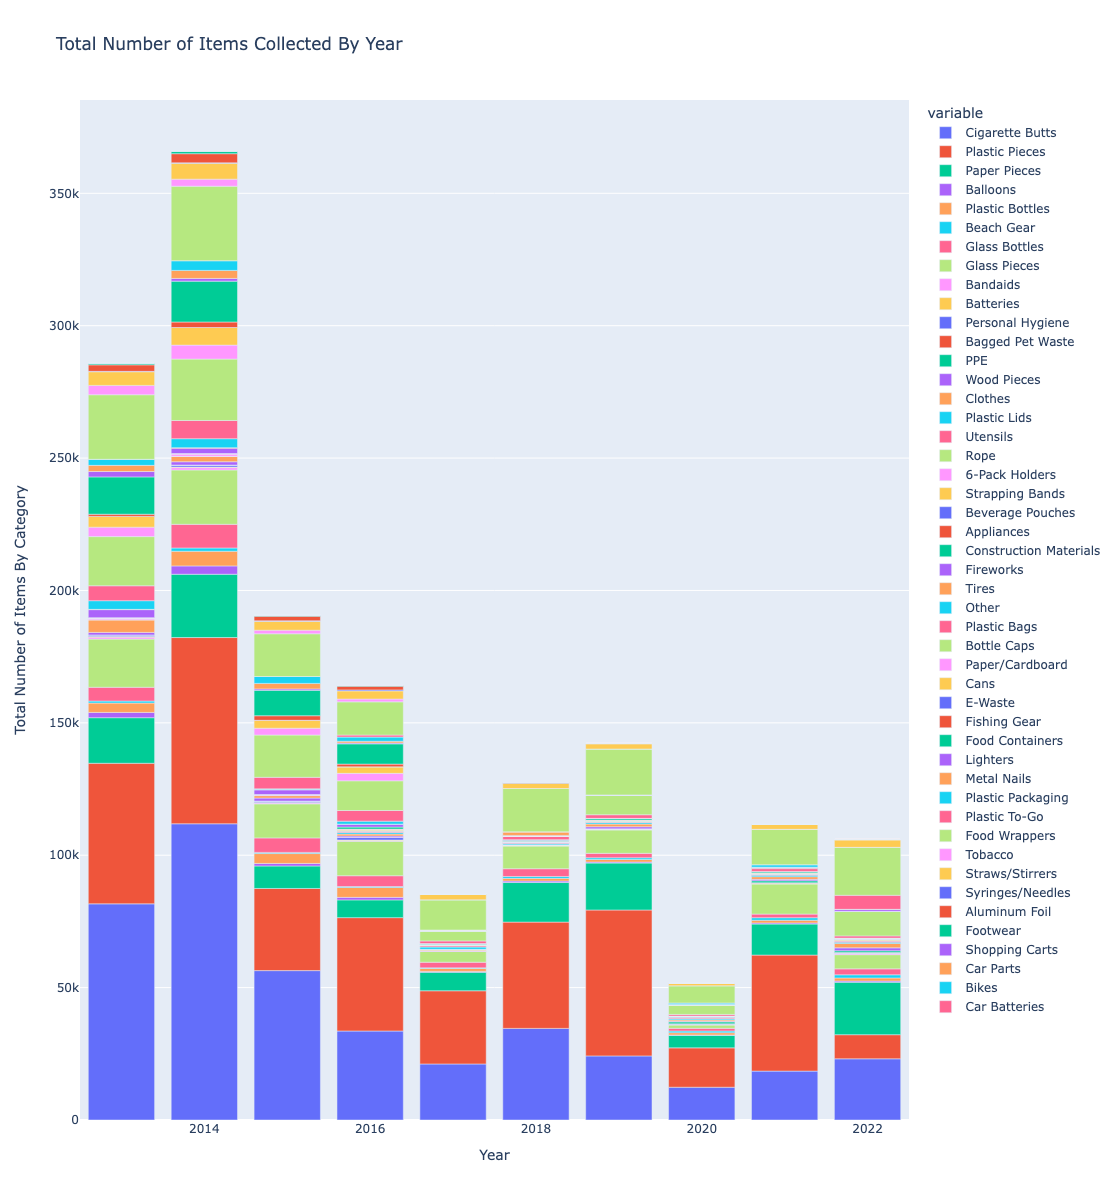

In [11]:
fig = px.bar(annual_data, x='Year', y=item_cols, title="Total Number of Items Collected By Year")
fig.update_layout(
    autosize=False,
    width=1100,
    height=1200,
    yaxis_title='Total Number of Items By Category',
    xaxis_title='Year',
)
fig.show()

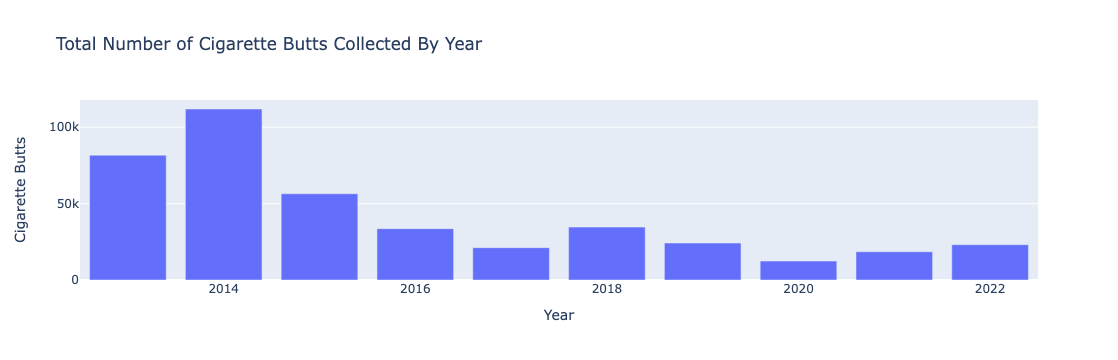

In [12]:
# Cigarette butts only

fig = px.bar(annual_data, x='Year', y='Cigarette Butts', title="Total Number of Cigarette Butts Collected By Year")
fig.show()

Above: Total number of cigarette butts collected each year 2013-2022.

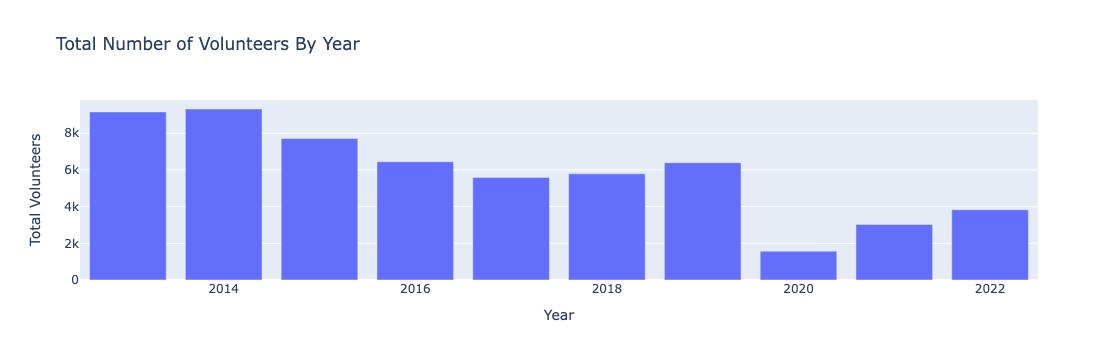

In [13]:
fig = px.bar(annual_data, x='Year', y='Total Volunteers', title="Total Number of Volunteers By Year")
fig.show()

## Cleanup Time Spent vs Amount of Trash Collected

Each event has a varying number of adult and youth volunteers, and number of hours spent cleaning up. 
(Note: some years, like 2014, seem to be mixed and may need verification)

In [14]:
# Add total items to annual data
col_sum = sos_data.groupby(sos_data.Date.dt.year)['Total Items'].sum()
col_sum = col_sum.reset_index(drop=True)
annual_data = pd.concat([annual_data, col_sum], axis=1)

Number of hours reported seem a bit variable, so we'll look at the correlation between total volunteers and total number of items collected by year.

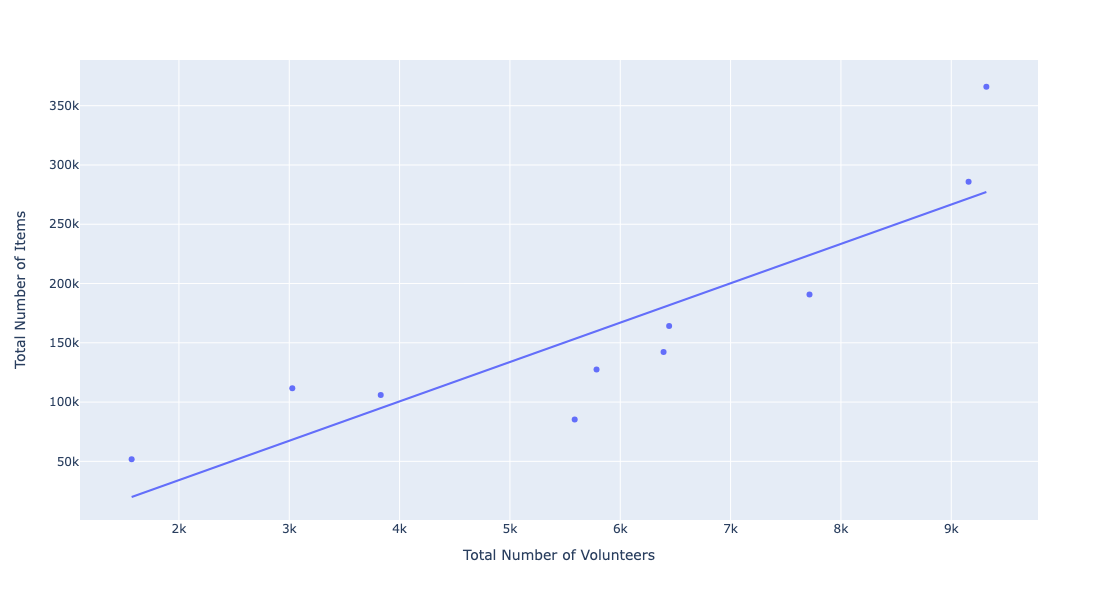

In [15]:
fig.data = []
fig = px.scatter(annual_data, 
                 x='Total Volunteers', 
                 y='Total Items', 
                 trendline="ols")
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    yaxis_title='Total Number of Items',
    xaxis_title='Total Number of Volunteers',
)
fig.show()

Get the coefficient of determination and p-value for number of volunteers vs number of items.

In [16]:
results = px.get_trendline_results(fig)

stats = [["", ""],
         ["R Squared", ""],
         ["p-value", ""],
         ["f(x)", ""]]

for idx in range(1):
    stats[1][idx + 1] = "{:.5f}".format(results.px_fit_results[idx].rsquared)
    stats[2][idx + 1] = "{}".format(results.px_fit_results[idx].pvalues[1])
    params = results.px_fit_results[idx].params
    stats[3][idx + 1] = "{:.1f}x + {:.1f}".format(params[1], params[0])

table = tabulate.tabulate(stats, tablefmt='html')
table

,
R Squared,0.76382
p-value,0.0009455106982339951
f(x),33.2x + -32265.1


There's a significant correlation between number of volunteers and number of items collected for each year, which suggests that the number of items collected in a year might depend on the number of volunteers doing beach cleanups that year. 
So the fewer cigarette butts collected in 2020 may have been a result of fewer people being out during the pandemic, and not necessarily due to regulations around smoking in certain locations.

## Number of Cigarette Butts by Location in 2022

In [17]:
sos22 = sos_data[sos_data['Date'].dt.year == 2022]
sos22 = sos22[['Cleanup Site', 'Cigarette Butts']]
sos22 = sos22.groupby('Cleanup Site').sum()
sos22 = sos22.reset_index()
sos22.sort_values(by=['Cigarette Butts'], ascending=False, inplace=True)
# Get the top 10 offenders
sos22 = sos22[:10]
# load lookup table for most common sites
lut = plots.geo_lut()
# join data sets
sos22 = pd.merge(sos22, lut, on="Cleanup Site")

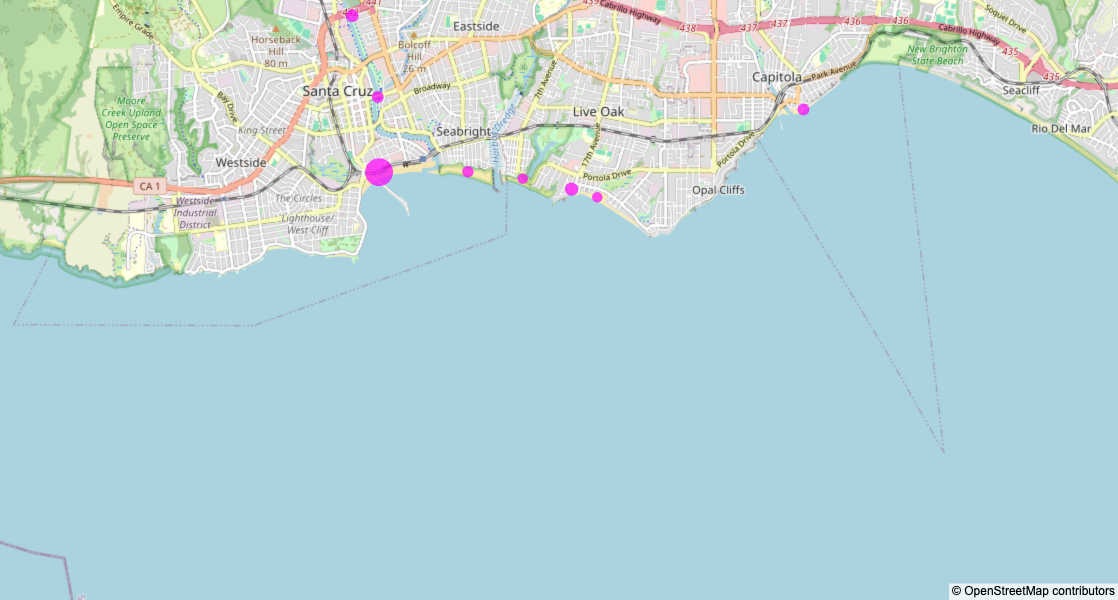

In [24]:
import importlib
importlib.reload(plots)
# Plot the 10 cleanup sites with the most cigarette butts in 2022
fig = plots.map_graph(sos22)
fig.show()

## The map above shows the top 10 spots where cigarette butts were collected in 2022

The circles (in fuchsia) are centered on the cleanup site, and the size of the circles correspond to the number of cigarette butts cleaned up from that site in 2022. You can hover over the circle to get more information, and you can zoom in and out on the map by sliding down and up with two fingers on your trackpad.